In [1]:
import igraph as ig
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram
from util.fosc import FOSC

import numpy as np
import os

In [2]:
mclSize = 2
pathFiles = "../dataset/pts2/"
listOfFiles    = os.listdir(pathFiles)

In [3]:
for fn in listOfFiles:
    if not fn.endswith(".csv"):continue
    varFileName = str(fn).rsplit(".", 1)[0]

In [4]:
matrix = np.genfromtxt(pathFiles+fn, dtype=float, delimiter=';', missing_values=np.nan)
distanceMatrix = np.zeros((matrix.shape[0], matrix.shape[0]))
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[0]):
        point1 = matrix[i]
        point2 = matrix[j]
        aux = np.sum((point2 - point1) ** 2)
        distanceMatrix[i,j] = np.sqrt(aux)
    #print(distanceMatrix)
dMax = distanceMatrix.max()
similarityMatrix = np.zeros_like(distanceMatrix)
similarityMatrix = 1 - (distanceMatrix/dMax)
print(similarityMatrix)
k = mclSize

[[1.         0.90012477 0.90012477 0.90012477 0.44168047 0.48525483
  0.52888946 0.23081479 0.25888471 0.18976313]
 [0.90012477 1.         0.85875509 0.85875509 0.47863597 0.54163361
  0.57333281 0.14776222 0.17300834 0.1049457 ]
 [0.90012477 0.85875509 1.         0.80024953 0.52888946 0.55825668
  0.60997474 0.28456629 0.30759374 0.24060334]
 [0.90012477 0.85875509 0.80024953 1.         0.35081098 0.40440101
  0.44168047 0.16849744 0.20060809 0.1303826 ]
 [0.44168047 0.47863597 0.52888946 0.35081098 1.         0.87515596
  0.90012477 0.12466608 0.12040306 0.07480541]
 [0.48525483 0.54163361 0.55825668 0.40440101 0.87515596 1.
  0.92509357 0.04987204 0.05118528 0.        ]
 [0.52888946 0.57333281 0.60997474 0.44168047 0.90012477 0.92509357
  1.         0.12466608 0.1260917  0.07480541]
 [0.23081479 0.14776222 0.28456629 0.16849744 0.12466608 0.04987204
  0.12466608 1.         0.95006238 0.95006238]
 [0.25888471 0.17300834 0.30759374 0.20060809 0.12040306 0.05118528
  0.1260917  0.95006

In [5]:
knnEdges = []
for i in range(similarityMatrix.shape[0]):
    indicesSorted = np.argsort(similarityMatrix[i])[::-1]  # Índices em ordem decrescente de similaridade
    kNearest = indicesSorted[1:k+1]
    for j in kNearest:
        if i < j:
            if (i,j) not in knnEdges:
                knnEdges.append((i,j))
        else:
            if (j,i) not in knnEdges:
                knnEdges.append((j,i))
    #print(knnEdges)
g = ig.Graph(similarityMatrix.shape[0], knnEdges)

In [18]:
sigmaEdges = []
sigmaWeight = []
for edge in g.es:
    uNeighbors = g.neighbors(edge.source)
    vNeighbors = g.neighbors(edge.target)
    #print(uNeighbors)
    #print(vNeighbors)
    upper = 0
    lowerLeft = 0
    lowerRight = 0
    emptyIntersection = True
    for x in uNeighbors:
        lowerLeft += (similarityMatrix[edge.source, x] ** 2)
        if x in vNeighbors:
            emptyIntersection = False
            upper += (similarityMatrix[edge.source, x] * similarityMatrix[edge.target, x])
    if emptyIntersection: continue

    for x in vNeighbors:
        lowerRight += (similarityMatrix[edge.target, x] ** 2)
    simWeighet = upper/ (np.sqrt(lowerLeft) + np.sqrt(lowerRight))
    sigmaEdges.append((edge.source, edge.target))
    sigmaWeight.append(simWeighet)

TS = np.sum(sigmaWeight)

sig = ig.Graph(similarityMatrix.shape[0])
for i in range(len(sigmaEdges)):
    sig.add_edge(sigmaEdges[i][0], sigmaEdges[i][1], weight=sigmaWeight[i])
#for i in range(len(sig.es)):
    #print(f"Aresta ({sig.es[i].source}, {sig.es[i].target}) = {sig.es['weight'][i]}")

3.597772932396567
Aresta (0, 1) = 0.5034544529772045
Aresta (0, 3) = 0.27575924784427375
Aresta (1, 3) = 0.2940145572911544
Aresta (0, 2) = 0.27575924784427375
Aresta (1, 2) = 0.2940145572911544
Aresta (4, 6) = 0.3179666985150785
Aresta (4, 5) = 0.32927403919014553
Aresta (5, 6) = 0.3072102515273861
Aresta (7, 9) = 0.33037291363640425
Aresta (7, 8) = 0.3303729136364043
Aresta (8, 9) = 0.3395740526430868


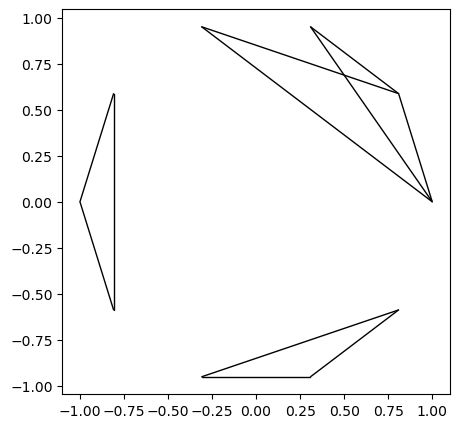

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
ig.plot(
    sig,
    target=ax,
    layout="circle",  # print nodes in a circular layout
    vertex_size=0.1,
    vertex_frame_width=4.0,
    vertex_frame_color="white",
    edge_label=sig.es['weight'],  # Adiciona os pesos das arestas como rótulos
)